# The outline of the work

First, I will download and prepare the dataset inside Google Drive.
I will use the same dataset for both the tasks


*   Image Reconstruction
*   Image Captioning




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
from torchvision.datasets.utils import download_url




import numpy as np

COLAB = False

/home/shadow2030/miniconda3/envs/stitching/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/shadow2030/miniconda3/envs/stitching/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/shadow2030/miniconda3/envs/stitching/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104warnERKNS_7WarningE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
if COLAB:
    #from google.colab import drive
    drive.mount('/content/drive')


In [3]:
if COLAB:
    !mkdir train
    !mkdir ./train/images
    flickrImagePath = "./train/images"

In [4]:
flickrImagePath = "./train/images"

In [5]:
epochs = 8
imgChannels = 3
imgSize = 256
numFeatures = 4
learningRate = 2e-4
batchSize = 8
numWorkers = 2


# Download the dataset and prepare the files

In [46]:
%pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [47]:
from itertools import filterfalse

from datasets import load_dataset

downloadDataset = True
saveDataset = False
if COLAB:
  if downloadDataset:
    print("DOWNLOADING DATASET")
    dataset = load_dataset("nlphuji/flickr30k")["test"] #it downloads it as a dict that contains a single dict named dict
    dataset = dataset.to_pandas()
    dataset["image"] = dataset["image"].apply(lambda x: x["bytes"])
    if saveDataset:
      print("SAVING DATASET")
      dataset.to_pickle("./drive/MyDrive/stitching/train/dataset.pkl")
  else:
    print("LOADING DATASET")
    dataset = pd.read_pickle("./drive/MyDrive/stitching/train/dataset.pkl")
    dataset["image"] = dataset["image"].apply(lambda x: x["bytes"])


  print("DATASET READY")
  dataset.head(5)

In [48]:
dataset

Devo salvare le immagini e il testo come file separati e non come dataframe.

In [49]:
saveCaptions = False
if saveCaptions:
  captions = dataset[["filename", "img_id", "caption"]]
  captions.head(10)
  captions.to_pickle("./train/captions/captions.pkl")

In [50]:
saveImages = True
if saveImages:
  images = dataset[["img_id", "filename", "image"]]
  images.head(10)
  for index, row in tqdm(images.iterrows(), total=images.shape[0]):
    name = row["filename"]
    image = Image.open(BytesIO(row["image"]))
    #image.save(f"./drive/MyDrive/stitching/train/images/{name}")
    image.save(f"./train/images/{name}")


KeyError: "None of [Index(['img_id', 'filename', 'image'], dtype='object')] are in the [index]"

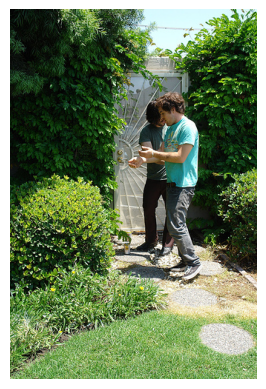

In [ ]:
def plot_image_from_bytes(image_bytes):
    img = Image.open(BytesIO(image_bytes))
    plt.imshow(img)
    plt.axis('off')  # Optional: Turn off axis if you don't want them
    plt.show()

image = dataset["image"][0]
plot_image_from_bytes(image)


Now every single image is saved in a separate file (./drive/MyDrive/stitching/train/images/) while all the captions are saved in a pandas dataframe (./drive/MyDrive/stitching/train/captions/captions.pkl)

# Image Reconstruction

I thought about using a U-Net but given the fact that it has residual inputs then it is not possible to just use it partially. The huggin face one cannot be used since it puts residual connections.
L'attention block prende molti GB di VRAM

## Model From Scratch

In [ ]:
import torch
import torch.nn as nn


class ConvBlock(nn.Module):
    def __init__(self, inChannels, outChannels, down=True, use_act = True, **kwargs):
        super(ConvBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(inChannels, outChannels, **kwargs) if down else nn.ConvTranspose2d(inChannels, outChannels, **kwargs),
            nn.InstanceNorm2d(outChannels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )


    def forward(self, x):
        return self.conv(x)


In [ ]:
class DownBlocks(nn.Module):
    def __init__(self, imgChannels, numFeatures = 64):
      super(DownBlocks, self).__init__()
      self.initial = nn.Sequential(
            nn.Conv2d(imgChannels, numFeatures, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.ReLU(inplace=True)
        )
      self.downBlocks = nn.ModuleList([   #for downsampling
            ConvBlock(numFeatures, numFeatures*2, kernel_size = 3, stride = 2, padding = 1),
            ConvBlock(numFeatures*2, numFeatures*4,kernel_size = 3, stride = 2, padding = 1 )

        ])


    def forward(self, x):
        x = self.initial(x)
        for layer in self.downBlocks:
            x = layer(x)
        #print(x.shape) torch.Size([2, 36, 64, 64])
        return x


    def saveWeights(self, optimizer, filename, epoch = 0):
      print(f"=> Saving DownBlock to {filename}DownBlock.pth")
      checkpointDown = {
        "state_dict": self.downBlocks.state_dict(),
        "optimizer":  optimizer.state_dict(),
        "epoch": epoch
        }

      #print(checkpointDown)
      torch.save(checkpointDown, f"{filename}DownBlock.pth")
      print(f"=> Done saving DownBlock to {filename}DownBlock.pth")


    def loadWeights(self, checkpoint_file, optimizer,  lr = 0.001, checkpointDown_file = None, checkpointUp_file = None):
      print("=> Loading Checkpoints")
      if checkpointDown_file is not None:
        print(f"=> Loading DownBlock from {checkpointDown_file}")
        checkpointDown = torch.load(checkpointDown_file, map_location="cuda" if torch.cuda.is_available() else "cpu")
        self.downBlocks.load_state_dict(checkpointDown["state_dict"])
        optimizer.load_state_dict(checkpointDown["optimizer"])

      else:
        print(f"=> Loading DownBlock from {checkpoint_file}DownBlock.pth")
        checkpoint = torch.load(f"{checkpoint_file}DownBlock.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")
        self.downBlocks.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])



In [ ]:
class UpBlocks(nn.Module):
    def __init__(self, imgChannels, numFeatures = 64):
      super(UpBlocks, self).__init__()
      self.upBlocks = nn.ModuleList([
            ConvBlock(numFeatures * 4, numFeatures  * 2, down = False, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            ConvBlock(numFeatures * 2, numFeatures * 1, down = False, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)

        ])

      self.last = nn.Conv2d(numFeatures * 1, imgChannels, kernel_size = 7, stride = 1, padding = 3, padding_mode = "reflect")

    def forward(self, x):
        for layer in self.upBlocks:
            x = layer(x)
        return torch.tanh(self.last(x))


    def saveWeights(self, optimizer, filename, epoch = 0):
      print(f"=> Saving UpBlock to {filename}UpBlock.pth")
      checkpointUp = {
        "state_dict": self.upBlocks.state_dict(),
        "optimizer":  optimizer.state_dict(),
        "epoch": epoch
        }
      torch.save(checkpointUp, f"{filename}UpBlock.pth")
      print(f"=> Done saving UpBlock to {filename}UpBlock.pth")


    def loadWeights(self, checkpoint_file, optimizer,  lr = 0.001, checkpointDown_file = None, checkpointUp_file = None):
      print("=> Loading Checkpoints")
      if checkpointUp_file is not None:
        print(f"=> Loading UpBlock from {checkpointUp_file}")
        checkpointUp = torch.load(checkpointUp_file, map_location="cuda" if torch.cuda.is_available() else "cpu")
        self.upBlocks.load_state_dict(checkpointUp["state_dict"])
        optimizer.load_state_dict(checkpointUp["optimizer"])

      else:
        print(f"=> Loading UpBlock from {checkpoint_file}UpBlock.pth")
        checkpoint = torch.load(f"{checkpoint_file}UpBlock.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")
        self.upBlocks.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])

In [ ]:
class UNet(nn.Module):
  def __init__(self, imgChannels, numFeatures = 64):
    super(UNet, self).__init__()
    self.downBlocks = DownBlocks(imgChannels, numFeatures=numFeatures)
    self.upBlocks = UpBlocks(imgChannels, numFeatures=numFeatures)




  def forward(self, x):

    x = self.downBlocks(x)
    #print(x.shape)
    x = self.upBlocks(x)
    #print(x.shape)

    return x




  def saveWeights(self, optimizer, modelName, epoch = 0):
    #save in two different state dictionaries downblocks and upblocks
    print(f"=> Saving checkpoint to {modelName}.pth")
    checkpoint = {
        "state_dict": self.state_dict(),
        "optimizer":  optimizer.state_dict(),
        "epoch": epoch
        }
    torch.save(checkpoint, f"{modelName}.pth")
    print("=> Done saving checkpoint to", modelName)





  def loadWeights(self, modelName, optimizer = None,  lr = 0.001):
    #load from two different state dictionaries downblocks and upblocks

    print("=> Loading Checkpoint from", modelName)
    checkpoint = torch.load(f"{modelName}.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")
    self.load_state_dict(checkpoint["state_dict"])
    if optimizer is not None:
      optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    print("=> Done loading checkpoint from", modelName)









### Test

In [ ]:
imgChannels = 3
imgSize = 256
x = torch.randn((2, imgChannels, imgSize, imgSize))
model = UNet(imgChannels, 9)

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999))
print(model(x).shape)



torch.Size([2, 36, 64, 64])
torch.Size([2, 3, 256, 256])


In [ ]:
checkpointsDir = "drive/MyDrive/stitching/checkpoints"

In [ ]:
!ls "drive/MyDrive/stitching/checkpoints/"

In [ ]:
checkPointUNet = f"{checkpointsDir}/UNetWeights"
checkPointTest = f"{checkPointUNet}/Test"

#model.saveWeights(optimizer,checkPointTest)
print(model(x).shape)

In [ ]:
loadCheckPoint = f"{checkpointsDir}/UNetWeights/firstUnet"
down = DownBlocks(imgChannels, numFeatures=4)
up = UpBlocks(imgChannels, numFeatures=4)

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999))

down.loadWeights(loadCheckPoint, optimizer)
up.loadWeights(loadCheckPoint, optimizer)

modelCombined = UNet(imgChannels, 4)
optimizer = optim.Adam(modelCombined.parameters(), lr=0.001, betas=(0.5, 0.999))
modelCombined.loadWeights(loadCheckPoint, optimizer)


## Dataloader


In [ ]:
from PIL import Image
from torch.utils.data import Dataset
import os
import numpy as np
import torch
import albumentations as transforms
from albumentations.pytorch import ToTensorV2

In [ ]:
class Flickr30k(Dataset):
    def __init__(self,
                  imagePath = flickrImagePath,
                  captionPath = None,
                  transform=transforms.Compose([
                        transforms.Resize(height = 32, width = 32),
                        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], max_pixel_value=255),
                        ToTensorV2()
                  ]),
                 targetImageSize = 32
        ):
        super(Dataset, self).__init__()
        self.path = imagePath
        self.data = os.listdir(self.path)

        print(f"Reading image data from: {self.path}")

        if targetImageSize != 32:
           transform=transforms.Compose([
                        transforms.Resize(height = targetImageSize, width = targetImageSize),
                        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], max_pixel_value=255),
                        ToTensorV2()
                  ])

        self.transform = transform

        self.imageData = [image for image in self.data if os.path.isfile(os.path.join(self.path, image))]

        self.lenImageData = len(self.data)


    def __len__(self):
        return len(self.data)


    def __getitem__(self, index):

      #image  = Image.open(os.path.join(self.path, self.imageData[index % self.lenImageData])).convert('RGB')
      image  = Image.open(os.path.join(self.path, self.imageData[index])).convert('RGB')
      image = np.array(image)

      if self.transform is not None:
            image = self.transform(image = image)

            image = image["image"].float()

      return image






## Train Image Reconstruction


In [ ]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split


from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image
from time import time

import numpy as np


from PIL import Image
import albumentations as transforms
from albumentations.pytorch import ToTensorV2
import os


ModuleNotFoundError: No module named 'tensorboard'

In [ ]:
def UNet_trainFN(model, loaderTrain, loaderVal, optimizer, mse, epoch, writer, scalar, dataset):
  """
  train for a single epoch
  """
  print("Training Model\n")
  loop = tqdm(loaderTrain, leave=True)
  step = 0
  device = "cuda" if torch.cuda.is_available() else "cpu"

  total_train_loss = 0.0

  model.train()

  for idx, image in enumerate(loop):

    realImage = image.to(device)

    with torch.cuda.amp.autocast_mode.autocast():
      generatedImage = model(realImage)

      loss = mse(realImage, generatedImage)

    total_train_loss += loss.item()

    avg_train_loss = total_train_loss / (idx + 1)  # Calculate average loss up to the current iteration
    loop.set_postfix(Loss=avg_train_loss, epoch=epoch)




    optimizer.zero_grad()
    scalar.scale(loss).backward()
    scalar.step(optimizer)
    scalar.update()

    loop.set_postfix(Loss = loss.item(), epoch = epoch)
  if loaderVal is not None:

    print("Validating Model\n")
    loop_val = tqdm(loaderVal, leave=True)

    model.eval()
    total_val_loss = 0.0


    with torch.no_grad():
        for idx, val_image in enumerate(loop_val):
            val_realImage = val_image.to(device)

            val_generatedImage = model(val_realImage)

            val_loss = mse(val_realImage, val_generatedImage)
            total_val_loss += val_loss.item()

            avg_val_loss = total_val_loss / (idx + 1)  # Calculate average loss up to the current iteration
            loop_val.set_postfix(Val_Loss=avg_val_loss, epoch=epoch)

        avg_val_loss = total_val_loss / len(loaderVal)
        loop_val.set_postfix(Val_Loss=avg_val_loss, epoch=epoch)


    model.train()






In [ ]:
#parameters
epochs = 8
imgChannels = 3
imgSize = 256
numFeatures = 4
learningRate = 2e-4
batchSize = 8
numWorkers = 2

unetModelName = "firstUnet"
pathUNetWeights = f"drive/MyDrive/stitching/checkpoints/UNetWeights/{unetModelName}"
print(f"Model Path: {pathUNetWeights}")

Model Path: drive/MyDrive/stitching/checkpoints/UNetWeights/firstUnet


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on: {device}")
UNetModel = UNet(imgChannels=imgChannels, numFeatures = numFeatures).to(device)
optimizer = optim.Adam(UNetModel.parameters(), lr=learningRate, betas=(0.5, 0.999))
MSE = nn.MSELoss()
epochCheckpoint = 0
dataset = Flickr30k(imagePath = flickrImagePath, captionPath = None, targetImageSize = imgSize)
writer = SummaryWriter("logs")
Scalar = torch.cuda.amp.grad_scaler.GradScaler()

Training on: cpu
Reading image data from: ./train/images


/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:
datasetSize = len(dataset)
splitRatio = 0.8

trainSize = int(datasetSize * splitRatio)
valSize = datasetSize - trainSize

train_dataset, val_dataset = random_split(dataset, [trainSize, valSize])


In [ ]:
train_UNet = False
load_UNet = True
fullLoader = DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=numWorkers, pin_memory=True)
loaderTrain = DataLoader(train_dataset, batch_size=batchSize, shuffle=True, num_workers=numWorkers, pin_memory=True)
loaderVal = DataLoader(val_dataset, batch_size=batchSize, shuffle=True, num_workers=numWorkers, pin_memory=True)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on: {device}")
if load_UNet:
    #check if exists
  if os.path.exists(f"{pathUNetWeights}.pth"):
    print("Loading Model Weights")
    UNetModel.loadWeights(pathUNetWeights, optimizer, lr = learningRate)
  else:
    print(f"No Model Found in {pathUNetWeights}")
  if train_UNet:
    for epoch in range(epochs):
      UNet_trainFN(UNetModel, loaderTrain, loaderVal, optimizer, MSE, epoch, writer, Scalar, dataset)
      #save the model
      UNetModel.saveWeights(optimizer, pathUNetWeights, epoch)

Training on: cpu
Loading Model Weights
=> Loading Checkpoint from drive/MyDrive/stitching/checkpoints/UNetWeights/firstUnet
=> Done loading checkpoint from drive/MyDrive/stitching/checkpoints/UNetWeights/firstUnet


In [ ]:
checkpoint = torch.load("drive/MyDrive/stitching/checkpoints/UNetWeights/firstUnet.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(checkpoint["state_dict"].keys())

odict_keys(['downBlocks.initial.0.weight', 'downBlocks.initial.0.bias', 'downBlocks.downBlocks.0.conv.0.weight', 'downBlocks.downBlocks.0.conv.0.bias', 'downBlocks.downBlocks.1.conv.0.weight', 'downBlocks.downBlocks.1.conv.0.bias', 'upBlocks.upBlocks.0.conv.0.weight', 'upBlocks.upBlocks.0.conv.0.bias', 'upBlocks.upBlocks.1.conv.0.weight', 'upBlocks.upBlocks.1.conv.0.bias', 'upBlocks.last.weight', 'upBlocks.last.bias'])


In [ ]:
#load another model with the same weights

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on: {device}")
UNetModel2 = UNet(imgChannels=imgChannels, numFeatures = numFeatures).to(device)
optimizer2 = optim.Adam(UNetModel2.parameters(), lr=learningRate, betas=(0.5, 0.999))
UNetModel2.loadWeights(pathUNetWeights, optimizer2, epochCheckpoint)


Training on: cpu
=> Loading Checkpoint from drive/MyDrive/stitching/checkpoints/UNetWeights/firstUnet
=> Done loading checkpoint from drive/MyDrive/stitching/checkpoints/UNetWeights/firstUnet


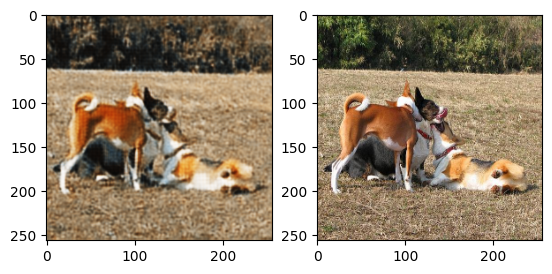

In [ ]:
import matplotlib.pyplot as plt
    #plot them on the same line

image = next(iter(loaderVal))[0]

f, axarr = plt.subplots(1,2)
axarr[0].imshow(UNetModel(image).to("cpu").detach().permute(1,2,0) * 0.5 + 0.5)
axarr[1].imshow(np.array(image.permute(1,2,0)) * 0.5 + 0.5)
plt.show()

In [ ]:
transform=transforms.Compose([
                        transforms.Resize(height = 256, width = 256),
                        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], max_pixel_value=255),
                        ToTensorV2()
                  ])

image  = Image.open("./home.jpg").convert('RGB')
image = np.array(image)

image = transform(image = image)

image = image["image"].float()

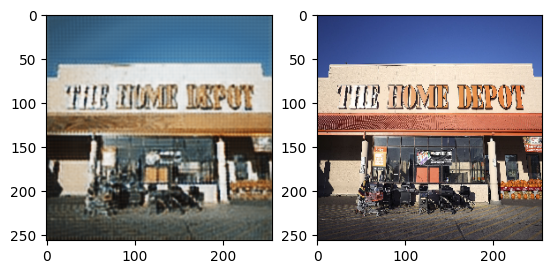

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#UNetModel = UNet(imgChannels=imgChannels, numFeatures = 4).to(device)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(UNetModel(image.to(device)).to("cpu").detach().permute(1,2,0) * 0.5 + 0.5)
axarr[1].imshow(np.asarray(image.permute(1,2,0)) * 0.5 + 0.5)
plt.show()

#

# Image Captioning

Codice non testato preso da un altro mio progetto


## Model

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

import numpy as np


In [7]:
class EncoderCNN(nn.Module):
    def __init__(self, embedSize, trainCNN = False):
        super(EncoderCNN, self).__init__()
        self.trainCNN = False
        self.embedSize = embedSize

        self.inception = models.inception_v3(pretrained = True, aux_logits = True)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embedSize)
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(0.5)

        for name, param in self.inception.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = self.trainCNN



    def forward(self, images):
        features = self.inception(images)[0]


        x = self.relu(features)
        x = self.dropout(x)

        return x


In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, embedSize, hiddenSize, vocabSize, numLayers):
        super(DecoderRNN, self).__init__()

        self.embed = nn.Embedding(vocabSize, embedSize)
        self.lstm = nn.LSTM(embedSize, hiddenSize, numLayers)
        self.linear = nn.Linear(hiddenSize, vocabSize)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, features, captions, captionLengths = 50):
        embeddings = self.dropout(self.embed(captions))


        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim = 0)

        output, _ = self.lstm(embeddings)

        output = self.linear(output)


        return output

In [9]:
class CNNtoRNN(nn.Module):
    def __init__(self, embedSize, hiddenSize, vocabSize, numLayers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embedSize=embedSize)
        self.decoderRNN = DecoderRNN(embedSize=embedSize, hiddenSize=hiddenSize, vocabSize=vocabSize, numLayers=numLayers)

    def forward (self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)

        return outputs

    def captionImage(self, image, vocabulary, maxLenght=50):
        resultCaption = []

        model.eval()

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(maxLenght):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                print(output)
                predicted = output.argmax(0)
                resultCaption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.intToString[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.intToString[idx] for idx in resultCaption]
            



    def saveWeights(self, optimizer, modelName, epoch = 0):
        #save in two different state dictionaries downblocks and upblocks
        print(f"=> Saving checkpoint to {modelName}.pth")
        checkpoint = {
            "state_dict": self.state_dict(),
            "optimizer":  optimizer.state_dict(),
            "epoch": epoch
            }
        torch.save(checkpoint, f"{modelName}.pth")
        print("=> Done saving checkpoint to", modelName)





    def loadWeights(self, modelName, optimizer = None,  lr = 0.001):
      #load from two different state dictionaries downblocks and upblocks

      print("=> Loading Checkpoint from", modelName)
      checkpoint = torch.load(f"{modelName}.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")
      self.load_state_dict(checkpoint["state_dict"])
      if optimizer is not None:
        optimizer.load_state_dict(checkpoint["optimizer"])

      for param_group in optimizer.param_groups:
          param_group["lr"] = lr
      print("=> Done loading checkpoint from", modelName)



## Dataset


In [10]:
import pandas as pd
import os
import spacy        #tokenizer
import torch
from  torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import albumentations as transforms
from albumentations.pytorch import ToTensorV2
import random
import numpy as np

spacyEng = spacy.load("en_core_web_sm")

In [11]:
class Vocabulary():
    def __init__(self, freqThreshold):
        self.freqThreshold = freqThreshold
        self.intToString = {0: "<PAD>",
                            1: "<SOS>",
                            2: "<EOS>",
                            3: "<UNK>"}
        self.stringToInt = {"<PAD>": 0,
                            "<SOS>": 1,
                            "<EOS>": 2,
                            "<UNK>": 3}
    def __len__(self):
        return len(self.intToString)

    @staticmethod
    def tokenizerEng(text):
        return [tok.text.lower() for tok in spacyEng.tokenizer(text)]


    def buildVocabulary(self, captions):
        frequencies = {}
        index = 4   #we already have used the 0...3 indexed

        for caption in captions:
            for word in self.tokenizerEng(caption):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                if frequencies[word] == self.freqThreshold:
                    self.intToString[index] = word
                    self.stringToInt[word] = index
                    index += 1


    def numericalize(self, caption):
        return [self.stringToInt[word] if word in self.stringToInt
                else self.stringToInt["<UNK>"]
                for word in self.tokenizerEng(caption)]


In [12]:
class FlickrCaptioning(Dataset):

  def __init__(self, rootDir, captionsPath,
               transform=transforms.Compose([
                        transforms.Resize(height = 300, width = 300),
                        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], max_pixel_value=255),
                        ToTensorV2()
                  ]), targetImageSize = 300,
               freqThreshold = 5, numberOfCaptions = 5):

    if numberOfCaptions > 5:
      print("Max number of captions is 5. Setting 5.")
      numberOfCaptions = 5

    self.rootDir = rootDir
    self.captionsPath = captionsPath
    self.numberOfCaptions = numberOfCaptions

    #read df from pickle

    self.df = pd.read_pickle(captionsPath)  #filename, img_id, caption
    self.transform = transform
    if targetImageSize != 256:
      transform=transforms.Compose([
                        transforms.Resize(height = targetImageSize, width = targetImageSize),
                        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], max_pixel_value=255),
                        ToTensorV2()
                  ])



    self.vocab = Vocabulary(freqThreshold)

    allCaptions = []
    flattenCaption = [] #used for building vocabulary
    for caption in self.df["caption"]:
        allCaptions.append(caption.tolist())
        flattenCaption.extend(caption)


    self.vocab.buildVocabulary(flattenCaption)


  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):

    """
    Returns image and a list of numericalized captions in a list
    (in case there is one caption it will be a list of a single list of numericalized captions)
    """

    imageName = self.df["filename"][index]
    captions = self.df["caption"][index].tolist()

    image = Image.open(os.path.join(self.rootDir, imageName)).convert("RGB")
    #convert to numpy

    image = np.array(image)

    if self.transform is not None:
      image = self.transform(image = image)

      image = image["image"].float()

    numericalizedCaption = []

    
    for caption in captions[:self.numberOfCaptions]:
        tmp = [self.vocab.stringToInt["<SOS>"]]
        tmp.extend(self.vocab.numericalize(caption))
        tmp.append(self.vocab.stringToInt["<EOS>"])
        numericalizedCaption.append(torch.tensor(tmp))
    return image, numericalizedCaption



In [13]:
class MyCollate:
    def __init__(self, padIDX):
      self.padIDX = padIDX
    def __call__(self, batch):
      imgs = [item[0].unsqueeze(0) for item in batch]
      imgs = torch.cat(imgs, dim=0)

      targets = [random.choice(item[1]) for item in batch]
      targets = pad_sequence(sequences=targets, batch_first=False, padding_value=self.padIDX)

      return imgs, targets

## Train Image Captioning

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim


from tqdm import tqdm

In [15]:
#take a random image and caption it
def plotAndCaption(model):

  #take random image from the loader
  for batch_idx, (imgs, captions) in enumerate(loader):
    image = imgs[0]
    #add a dimension
    image = image.unsqueeze(0).to(device)
    captionT = ""
    for idx in captions[:, :1]:
      captionT += dataset.vocab.intToString[idx.item()] + " "
    

    print(image.shape)
    break


  model.eval()
  caption = model.captionImage(image, dataset.vocab)
  print(caption)
  print(f"The true caption is: {captionT}")
  plt.imshow(image[0].permute(1, 2, 0).to("cpu") * 0.5 + 0.5)
  plt.show()


In [16]:
plotAndCaption(model)

NameError: name 'model' is not defined

torch.Size([1, 3, 300, 300])
tensor([-3.7480, 11.1049,  0.0742,  ..., -4.2727, -3.3772, -3.6711],
       device='cuda:0')
tensor([-7.1098,  2.3343, -0.4411,  ..., -6.7226, -6.7299, -6.6428],
       device='cuda:0')
tensor([-5.1360,  0.8704, -0.3517,  ..., -4.7849, -4.4970, -5.1819],
       device='cuda:0')
tensor([-6.8538,  0.3018, -0.4409,  ..., -6.7997, -6.8891, -7.1691],
       device='cuda:0')
tensor([-6.7798, -0.4710,  0.0475,  ..., -6.4451, -7.0842, -7.1232],
       device='cuda:0')
tensor([-5.0927, -0.0955, -0.2407,  ..., -4.8881, -4.7930, -5.0965],
       device='cuda:0')
tensor([-6.9032, -0.1973, -0.2140,  ..., -6.9107, -7.2333, -7.2414],
       device='cuda:0')
tensor([-6.8505, -0.9050,  0.2223,  ..., -6.5459, -7.3495, -7.2243],
       device='cuda:0')
tensor([-5.0980, -0.4113, -0.0666,  ..., -4.9221, -4.9353, -5.1373],
       device='cuda:0')
tensor([-5.8524, -0.8363,  0.5377,  ..., -6.2354, -6.5909, -6.4512],
       device='cuda:0')
tensor([-5.6591, -1.0567, -0.2232,  ..., 

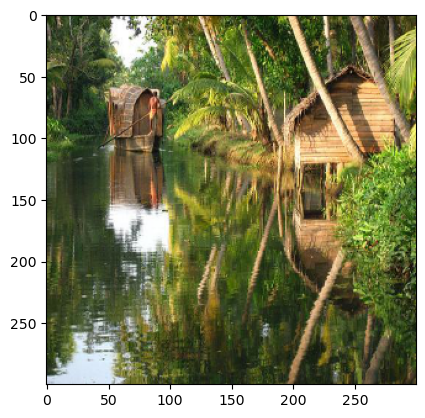

In [ ]:
plotAndCaption(model=model)

In [ ]:
#create a tensor whose only value is the one given by dataset.vocab.stringToInt["<SOS>"]


In [29]:
def fullImageCaptioning_trainFN(model, loader, optimizer, criterion, device, epoch):
  model.train()
  loop = tqdm(loader, leave = True)

  lossAvg = 0

  for batch_idx, (imgs, captions) in enumerate(loop):
    model.train()


      
    imgs = imgs.to(device = device)
    captions = captions.to(device = device)

    
    outputs = model(imgs, captions[:-1])


    loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))


    """
    #random int
    randInt = torch.randint(1, len(captions) , size = (1,1))[0][0].item()
    truncatedCaptions = captions[:randInt]
    outputs = model(imgs, truncatedCaptions[:-1])

    loss = criterion(outputs.reshape(-1, outputs.shape[2]), truncatedCaptions.reshape(-1))
    """
    """
    CAMBIARE IL METODO DI TRAINING E FARGLI PREDIRE ANCHE GLI ELEMENTI INTEMEZZI ALLA CAPTION
    """
   # print("PRINTING OUTPUTS")
   # print(outputs)
   # print(outputs.shape)

   # print("PRINTING CAPTIONS")
   # print(captions)
   # print(captions.shape)

    lossAvg += loss.item()


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loop.set_postfix(loss = loss.item(), lossAvg = lossAvg/(batch_idx+1), epoch = epoch)



In [24]:
embedSize = 512
hiddenSize = 512

numLayers = 2
learningRate = 3e-4
numEpoch = 100

In [19]:
dataset = FlickrCaptioning(rootDir = "train/images", captionsPath = "./train/captions/captions.pkl", targetImageSize = 299, numberOfCaptions= 1)
loader = DataLoader(dataset = dataset, batch_size = 2, shuffle = True, collate_fn = MyCollate(padIDX = dataset.vocab.stringToInt["<PAD>"]), pin_memory=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")
vocabSize = len(dataset.vocab)
print(f"Vocab size: {vocabSize}")


Using cuda
Vocab size: 7623


In [30]:
model = CNNtoRNN(embedSize=embedSize, hiddenSize=hiddenSize, vocabSize=vocabSize, numLayers=numLayers).to(device=device)
imageCaptioninglName = "revisitedModel"
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stringToInt["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learningRate)

100%|██████████| 15507/15507 [10:09<00:00, 25.42it/s, epoch=0, loss=4.04, lossAvg=3.73]


=> Saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel.pth
=> Done saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel
torch.Size([1, 3, 300, 300])
tensor([-15.4136,  19.9627,   0.3190,  ..., -12.5513, -15.5260,  -8.8841],
       device='cuda:0')
tensor([-14.5455,  -7.3930,  -2.8385,  ..., -11.8717, -14.4271,  -9.8641],
       device='cuda:0')
tensor([-10.9368,  -6.5616,  -1.7529,  ...,  -8.9606, -10.9456,  -7.4410],
       device='cuda:0')
tensor([-13.5745,  -7.5856,  -1.7063,  ...,  -9.8063, -13.4200,  -5.5073],
       device='cuda:0')
tensor([-12.6339,  -7.0514,  -3.7449,  ...,  -9.6429, -12.4786,  -9.3730],
       device='cuda:0')
tensor([-11.1923,  -7.6250,  -1.5605,  ...,  -8.6721, -11.1666,  -6.5346],
       device='cuda:0')
tensor([-9.7349, -5.4170, -1.4615,  ..., -6.4230, -9.7314, -6.1798],
       device='cuda:0')
tensor([-10.7485,  -7.1416,   0.4635,  ...,  -6.7945, -10.5929,  -3.9610],
       device='cuda:0')
tensor([-12.1340,  -7.

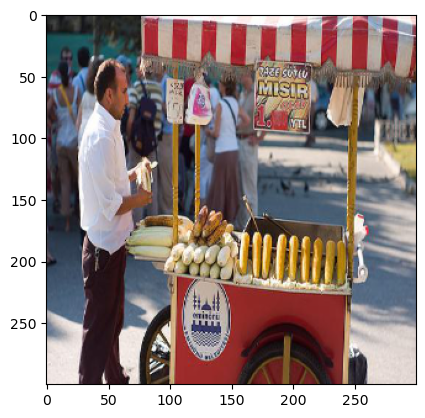

100%|██████████| 15507/15507 [09:59<00:00, 25.87it/s, epoch=1, loss=3.73, lossAvg=3.26]


=> Saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel.pth
=> Done saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel
torch.Size([1, 3, 300, 300])
tensor([-13.2768,  26.3668,   0.4826,  ..., -12.7129, -13.2647, -10.7278],
       device='cuda:0')
tensor([-14.8291, -10.2306,  -2.4930,  ..., -13.1692, -14.9817, -10.6586],
       device='cuda:0')
tensor([-11.6909,  -9.3683,  -1.4302,  ..., -11.5603, -11.7984,  -9.2283],
       device='cuda:0')
tensor([-15.2008, -12.5500,  -2.1294,  ..., -11.0449, -15.0728,  -5.5803],
       device='cuda:0')
tensor([-14.9213, -12.4074,  -3.6634,  ..., -11.6220, -15.0285, -12.1099],
       device='cuda:0')
tensor([-11.8516, -10.4446,  -1.9778,  ..., -10.3518, -11.9179,  -9.1824],
       device='cuda:0')
tensor([-12.2381, -11.5816,  -2.0964,  ...,  -8.9837, -12.2341,  -7.3200],
       device='cuda:0')
tensor([-14.1854, -14.3385,  -1.0789,  ...,  -7.5578, -14.1709,  -3.7956],
       device='cuda:0')
tensor([-13.7994

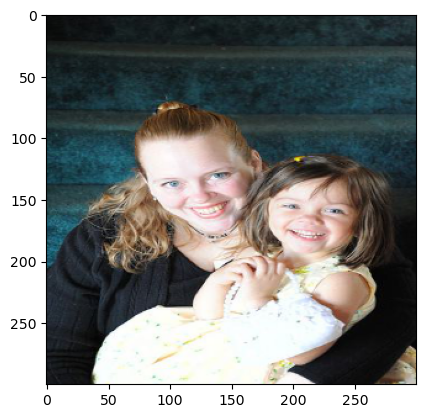

100%|██████████| 15507/15507 [08:43<00:00, 29.62it/s, epoch=2, loss=2.77, lossAvg=3.09]


=> Saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel.pth
=> Done saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel
torch.Size([1, 3, 300, 300])
tensor([-14.0153,  29.5719,  -0.3817,  ..., -14.1403, -14.1338, -10.9743],
       device='cuda:0')
tensor([-15.1966, -11.0390,  -2.5419,  ..., -15.1138, -15.3307,  -9.0275],
       device='cuda:0')
tensor([-14.1631, -11.2495,  -1.9417,  ..., -13.9192, -14.1488,  -9.2751],
       device='cuda:0')
tensor([-16.6356, -14.3893,  -3.2307,  ..., -15.3904, -16.6170,  -8.1080],
       device='cuda:0')
tensor([-16.0146, -14.7646,  -3.4678,  ..., -14.9332, -16.0920, -14.2884],
       device='cuda:0')
tensor([-13.4831, -12.3312,  -3.1747,  ..., -13.0042, -13.5357, -12.0637],
       device='cuda:0')
tensor([-14.4371, -15.3851,  -3.1865,  ..., -13.4656, -14.4861, -10.5683],
       device='cuda:0')
tensor([-14.1474, -15.8879,  -2.3010,  ..., -11.1327, -14.2306,  -5.8292],
       device='cuda:0')
tensor([-15.5391

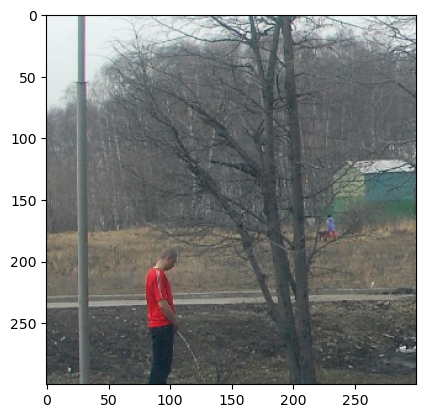

100%|██████████| 15507/15507 [08:41<00:00, 29.73it/s, epoch=3, loss=2.8, lossAvg=2.97] 


=> Saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel.pth
=> Done saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel
torch.Size([1, 3, 300, 300])
tensor([-12.1744,  29.8859,   0.1353,  ...,  -9.3758, -12.2438,  -8.8444],
       device='cuda:0')
tensor([-15.5708, -11.5655,  -2.8405,  ..., -12.5411, -15.7226,  -7.9630],
       device='cuda:0')
tensor([-13.7905, -11.7775,  -1.9757,  ..., -10.3258, -13.8101,  -6.6915],
       device='cuda:0')
tensor([-16.4094, -14.6751,  -3.6376,  ..., -11.6676, -16.3563,  -7.7200],
       device='cuda:0')
tensor([-16.4524, -17.1860,  -3.5291,  ..., -13.3264, -16.5314, -15.6648],
       device='cuda:0')
tensor([-13.6027, -13.9740,  -2.6677,  ..., -10.1409, -13.6293, -10.0565],
       device='cuda:0')
tensor([-16.5444, -18.9527,  -3.7143,  ..., -11.7922, -16.5886, -10.3547],
       device='cuda:0')
tensor([-13.5928, -12.5745,  -1.8296,  ...,  -7.6522, -13.6982,  -6.0145],
       device='cuda:0')
tensor([-14.7012

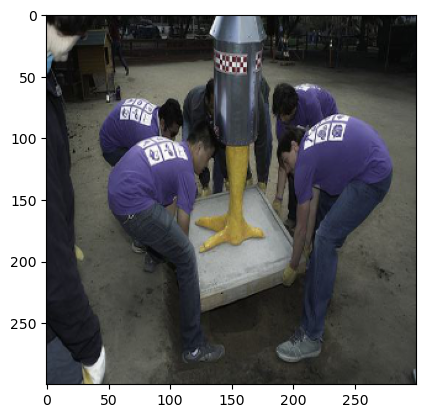

100%|██████████| 15507/15507 [08:41<00:00, 29.73it/s, epoch=4, loss=2.86, lossAvg=2.88]


=> Saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel.pth
=> Done saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel
torch.Size([1, 3, 300, 300])
tensor([-9.5068, 35.4894,  1.1809,  ..., -7.6964, -9.5612, -6.6186],
       device='cuda:0')
tensor([-17.1837, -12.7204,  -3.1116,  ..., -15.8839, -17.3437, -10.0372],
       device='cuda:0')
tensor([-13.7419, -10.7726,  -2.0207,  ..., -12.5762, -13.8057,  -8.2601],
       device='cuda:0')
tensor([-15.6190, -14.4369,  -3.6524,  ..., -14.6052, -15.5658,  -8.6562],
       device='cuda:0')
tensor([-16.5804, -15.2436,  -3.0575,  ..., -16.8500, -16.6948, -15.3875],
       device='cuda:0')
tensor([-13.4968, -11.9051,  -2.8771,  ..., -12.9521, -13.5963, -11.0372],
       device='cuda:0')
tensor([-14.8841, -14.8193,  -4.5864,  ..., -14.9971, -15.0648, -11.2246],
       device='cuda:0')
tensor([-14.0651, -15.4603,  -2.8490,  ..., -11.5453, -14.3491,  -6.3605],
       device='cuda:0')
tensor([-14.4468, -19.

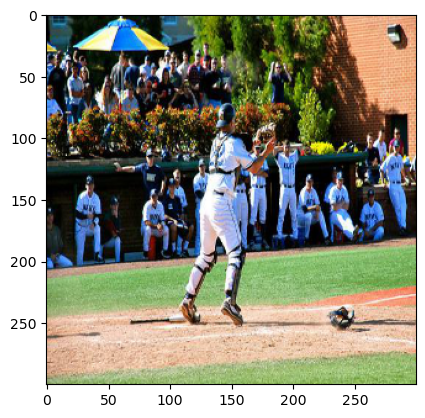

100%|██████████| 15507/15507 [08:37<00:00, 29.94it/s, epoch=5, loss=2.89, lossAvg=2.8] 


=> Saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel.pth
=> Done saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel
torch.Size([1, 3, 300, 300])
tensor([-9.3763, 36.1998,  0.7352,  ..., -7.3755, -9.3981, -7.0941],
       device='cuda:0')
tensor([-17.1979, -13.3182,  -3.2048,  ..., -14.6378, -17.3289, -10.0541],
       device='cuda:0')
tensor([-14.7145, -10.3693,  -1.8890,  ..., -11.6172, -14.8150,  -9.4872],
       device='cuda:0')
tensor([-15.8615, -16.0692,  -3.7374,  ..., -11.5502, -15.8716,  -8.6942],
       device='cuda:0')
tensor([-16.6865, -16.2592,  -3.5272,  ..., -15.7424, -16.7476, -16.7955],
       device='cuda:0')
tensor([-16.1866, -15.0075,  -3.5438,  ..., -13.8047, -16.2302, -13.2630],
       device='cuda:0')
tensor([-19.0406, -22.2506,  -4.8528,  ..., -14.5296, -19.1276, -10.7382],
       device='cuda:0')
tensor([-16.6569, -17.6195,  -3.1793,  ..., -11.3832, -16.8486,  -8.8861],
       device='cuda:0')
tensor([-16.3633, -19.

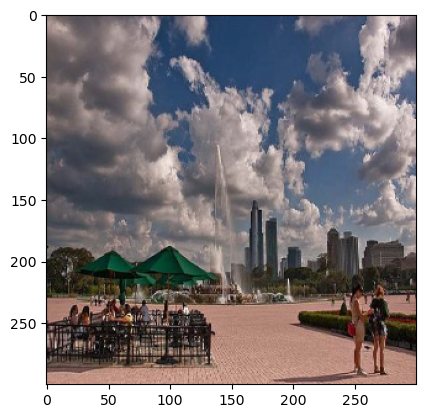

100%|██████████| 15507/15507 [08:35<00:00, 30.07it/s, epoch=6, loss=2.33, lossAvg=2.73]


=> Saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel.pth
=> Done saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel
torch.Size([1, 3, 300, 300])
tensor([-9.3671, 37.6793, -0.7386,  ..., -6.2197, -9.5088, -6.6051],
       device='cuda:0')
tensor([-17.3531, -12.5445,  -4.2384,  ..., -13.0189, -17.5232,  -7.7889],
       device='cuda:0')
tensor([-12.6371,  -8.6015,  -1.2725,  ...,  -8.3145, -12.7187,  -8.4597],
       device='cuda:0')
tensor([-15.8782, -15.1953,  -4.0149,  ..., -11.8487, -15.8710,  -7.6332],
       device='cuda:0')
tensor([-18.7854, -17.9597,  -3.7434,  ..., -15.1679, -18.8522, -17.5546],
       device='cuda:0')
tensor([-14.9368, -12.0031,  -3.0145,  ..., -11.8852, -14.9840, -11.9609],
       device='cuda:0')
tensor([-16.9992, -15.7796,  -3.1735,  ..., -12.2844, -17.0798, -10.4360],
       device='cuda:0')
tensor([-15.0565, -15.0850,  -2.5051,  ...,  -8.7839, -15.1924,  -7.3204],
       device='cuda:0')
tensor([-17.0295, -20.

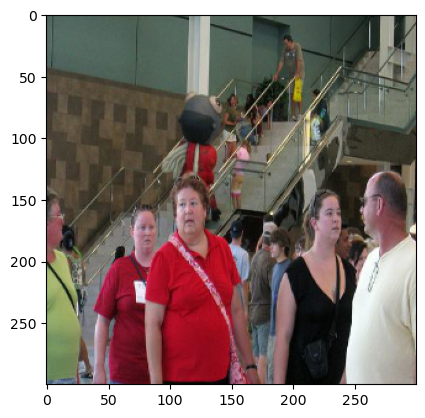

100%|██████████| 15507/15507 [08:35<00:00, 30.10it/s, epoch=7, loss=2.5, lossAvg=2.66] 


=> Saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel.pth
=> Done saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel
torch.Size([1, 3, 300, 300])
tensor([-11.2043,  36.5392,  -1.6940,  ..., -12.5047, -11.3447, -12.6116],
       device='cuda:0')
tensor([-16.9129, -12.2860,  -4.5531,  ..., -12.9218, -17.0750,  -8.1084],
       device='cuda:0')
tensor([-12.5349,  -9.0745,  -1.6496,  ...,  -9.0044, -12.5745,  -8.8702],
       device='cuda:0')
tensor([-16.9383, -16.6070,  -4.6516,  ..., -14.3771, -16.9270, -10.0829],
       device='cuda:0')
tensor([-17.5827, -15.1581,  -3.6420,  ..., -14.3976, -17.7257, -17.1706],
       device='cuda:0')
tensor([-14.5862, -10.5233,  -3.1677,  ..., -11.7583, -14.5979, -11.2510],
       device='cuda:0')
tensor([-18.0746, -16.1307,  -3.6244,  ..., -12.6459, -18.1950, -10.3325],
       device='cuda:0')
tensor([-14.5715, -14.9084,  -2.6826,  ...,  -8.9736, -14.7464,  -6.2407],
       device='cuda:0')
tensor([-17.9875

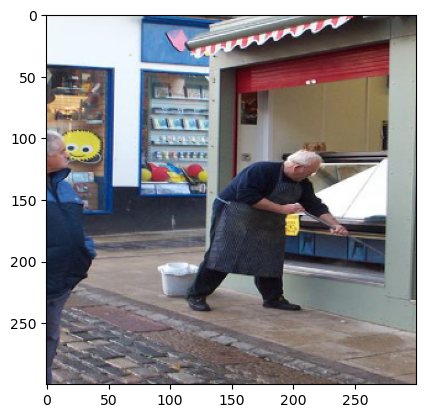

100%|██████████| 15507/15507 [08:22<00:00, 30.88it/s, epoch=8, loss=2.23, lossAvg=2.61]


=> Saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel.pth
=> Done saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel
torch.Size([1, 3, 300, 300])
tensor([-10.9187,  39.4136,  -1.2956,  ..., -10.7535, -11.0290, -12.4430],
       device='cuda:0')
tensor([-16.9984, -12.6737,  -4.5611,  ..., -12.1468, -17.2091,  -8.2594],
       device='cuda:0')
tensor([-12.4190,  -9.2729,  -1.0794,  ...,  -7.8628, -12.4676,  -6.9720],
       device='cuda:0')
tensor([-16.1594, -16.9318,  -4.4095,  ..., -12.4045, -16.1465,  -8.5394],
       device='cuda:0')
tensor([-18.1539, -17.6290,  -3.8083,  ..., -15.1429, -18.1886, -18.6585],
       device='cuda:0')
tensor([-14.8664, -10.6901,  -3.0794,  ..., -11.1704, -14.9111, -10.4752],
       device='cuda:0')
tensor([-18.1243, -19.6480,  -5.0934,  ..., -11.8246, -18.1769,  -9.0874],
       device='cuda:0')
tensor([-14.7274, -15.8975,  -3.4148,  ...,  -9.2325, -14.8496,  -6.8613],
       device='cuda:0')
tensor([-15.9571

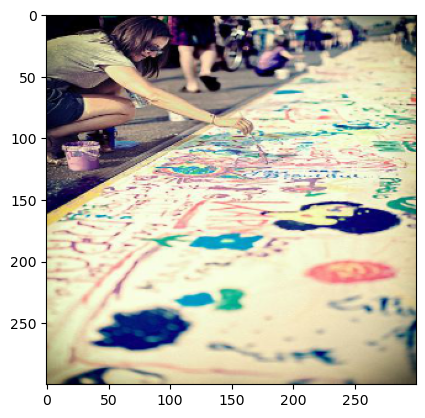

100%|██████████| 15507/15507 [08:11<00:00, 31.55it/s, epoch=9, loss=2.57, lossAvg=2.56]


=> Saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel.pth
=> Done saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel
torch.Size([1, 3, 300, 300])
tensor([ -9.9435,  43.5203,  -0.9364,  ..., -11.1965, -10.0909, -14.0116],
       device='cuda:0')
tensor([-16.2190, -11.6266,  -4.6597,  ..., -11.2128, -16.4330,  -8.7708],
       device='cuda:0')
tensor([-12.4010,  -9.2759,  -1.4246,  ...,  -7.2887, -12.4464,  -6.3151],
       device='cuda:0')
tensor([-16.1025, -16.7697,  -4.8758,  ..., -10.4836, -16.0744,  -7.9652],
       device='cuda:0')
tensor([-18.7911, -18.7240,  -4.2491,  ..., -14.1816, -18.8980, -20.1752],
       device='cuda:0')
tensor([-15.7338, -11.4394,  -3.7700,  ..., -11.3453, -15.7208, -10.3350],
       device='cuda:0')
tensor([-18.4765, -19.5677,  -5.8604,  ..., -12.4745, -18.4864,  -9.5167],
       device='cuda:0')
tensor([-14.7825, -15.5269,  -3.8477,  ...,  -8.9497, -14.9486,  -7.9175],
       device='cuda:0')
tensor([-17.9643

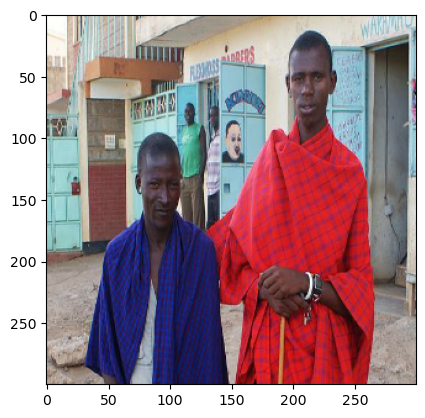

100%|██████████| 15507/15507 [08:12<00:00, 31.51it/s, epoch=10, loss=2.02, lossAvg=2.51]


=> Saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel.pth
=> Done saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel
torch.Size([1, 3, 300, 300])
tensor([-1.0570e+01,  4.6031e+01, -3.4723e-02,  ..., -8.3520e+00,
        -1.0615e+01, -1.0685e+01], device='cuda:0')
tensor([-15.8402, -11.3832,  -4.4455,  ..., -10.7269, -16.0693,  -8.5459],
       device='cuda:0')
tensor([-12.7938,  -9.1437,  -1.0294,  ...,  -7.5623, -12.8107,  -5.5451],
       device='cuda:0')
tensor([-15.9896, -16.3434,  -4.6250,  ..., -10.9732, -15.9583,  -7.7647],
       device='cuda:0')
tensor([-17.3833, -17.4114,  -4.1260,  ..., -13.5974, -17.4555, -19.6288],
       device='cuda:0')
tensor([-15.9356, -11.5515,  -4.3736,  ..., -12.5018, -15.9450,  -9.9681],
       device='cuda:0')
tensor([-18.1980, -19.6001,  -5.8255,  ..., -12.9576, -18.1951,  -9.0692],
       device='cuda:0')
tensor([-13.4254, -13.5655,  -3.3110,  ...,  -7.0834, -13.5306,  -5.5306],
       device='cuda:0

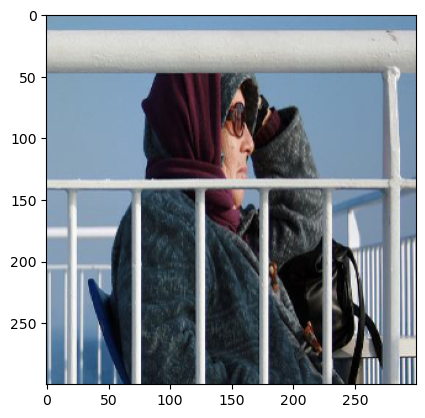

100%|██████████| 15507/15507 [08:10<00:00, 31.64it/s, epoch=11, loss=3.17, lossAvg=2.47]


=> Saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel.pth
=> Done saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel
torch.Size([1, 3, 300, 300])
tensor([-10.3057,  40.9205,  -1.8837,  ..., -13.0965, -10.4704, -14.9416],
       device='cuda:0')
tensor([-15.5468, -11.4019,  -4.7458,  ..., -12.6080, -15.7683,  -8.4770],
       device='cuda:0')
tensor([-13.2378,  -9.5039,  -1.4874,  ..., -10.8187, -13.2566,  -6.3045],
       device='cuda:0')
tensor([-15.4360, -13.6742,  -4.3698,  ..., -14.1815, -15.4095,  -8.0243],
       device='cuda:0')
tensor([-18.2202, -18.4625,  -5.1025,  ..., -17.9894, -18.3044, -20.7232],
       device='cuda:0')
tensor([-16.9456, -12.7281,  -4.4896,  ..., -15.2342, -16.9151,  -9.8923],
       device='cuda:0')
tensor([-18.6464, -16.2010,  -4.6789,  ..., -16.9903, -18.7755, -11.7672],
       device='cuda:0')
tensor([-14.8696, -11.5977,  -3.2140,  ..., -10.4445, -14.9301,  -4.6147],
       device='cuda:0')
tensor([-17.5367

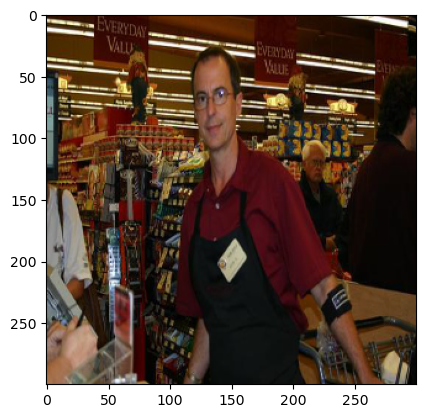

100%|██████████| 15507/15507 [08:39<00:00, 29.83it/s, epoch=12, loss=2.43, lossAvg=2.43]


=> Saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel.pth
=> Done saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel
torch.Size([1, 3, 300, 300])
tensor([-10.7271,  43.0478,  -1.0832,  ..., -11.9336, -10.8672, -15.1801],
       device='cuda:0')
tensor([-15.7916, -11.7433,  -4.7027,  ..., -12.2769, -16.0224,  -8.5454],
       device='cuda:0')
tensor([-13.2418,  -9.2249,  -1.7676,  ...,  -9.3812, -13.2441,  -6.9265],
       device='cuda:0')
tensor([-16.1424, -15.2832,  -4.7758,  ..., -12.6397, -16.1360,  -8.6934],
       device='cuda:0')
tensor([-16.7938, -17.0889,  -3.9987,  ..., -15.2266, -16.9024, -18.1593],
       device='cuda:0')
tensor([-16.1449, -12.2402,  -3.9910,  ..., -13.9078, -16.1465,  -8.8808],
       device='cuda:0')
tensor([-16.2456, -11.9713,  -4.3949,  ..., -14.3029, -16.3094, -11.8353],
       device='cuda:0')
tensor([-13.0603,  -9.6249,  -3.3171,  ...,  -8.2463, -13.1830,  -4.5276],
       device='cuda:0')
tensor([-17.2865

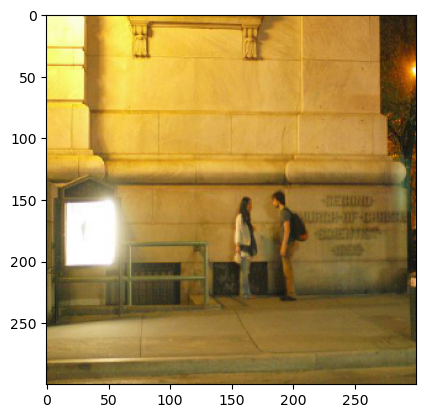

100%|██████████| 15507/15507 [11:00<00:00, 23.46it/s, epoch=13, loss=2.17, lossAvg=2.39]


=> Saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel.pth
=> Done saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel
torch.Size([1, 3, 300, 300])
tensor([-10.8858,  47.1610,  -1.4288,  ..., -12.9457, -10.9861, -16.0136],
       device='cuda:0')
tensor([-14.9082,  -9.4542,  -4.7703,  ..., -10.0753, -15.1362,  -7.2779],
       device='cuda:0')
tensor([-12.4674,  -6.9109,  -1.8144,  ...,  -6.9426, -12.4707,  -5.2399],
       device='cuda:0')
tensor([-16.1450, -13.6752,  -5.1021,  ..., -11.9276, -16.1376,  -9.7928],
       device='cuda:0')
tensor([-17.7191, -16.4448,  -5.2356,  ..., -15.6395, -17.8332, -19.8477],
       device='cuda:0')
tensor([-17.4549, -11.1679,  -4.6790,  ..., -13.7132, -17.4868,  -9.8222],
       device='cuda:0')
tensor([-17.4842, -11.3898,  -5.2371,  ..., -15.0615, -17.5215, -13.3821],
       device='cuda:0')
tensor([-15.1041, -11.2819,  -3.8931,  ...,  -9.1220, -15.2414,  -6.7234],
       device='cuda:0')
tensor([-18.3653

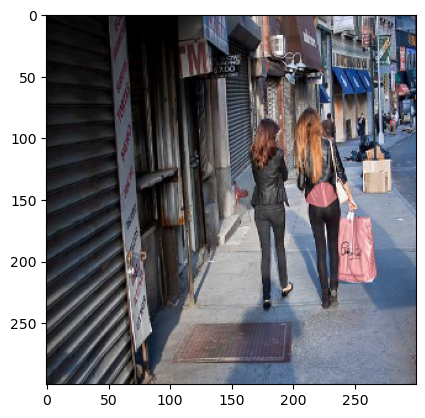

100%|██████████| 15507/15507 [11:18<00:00, 22.84it/s, epoch=14, loss=2.71, lossAvg=2.36]


=> Saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel.pth
=> Done saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel
torch.Size([1, 3, 300, 300])
tensor([-11.4488,  41.1968,  -1.5266,  ..., -12.7554, -11.4944, -15.1657],
       device='cuda:0')
tensor([-15.4755,  -9.3414,  -5.1574,  ..., -10.9384, -15.7055,  -9.0229],
       device='cuda:0')
tensor([-13.5715,  -6.7536,  -2.5122,  ...,  -9.1368, -13.5560,  -8.8934],
       device='cuda:0')
tensor([-15.8184, -12.5053,  -5.1185,  ..., -10.8435, -15.8222,  -8.9868],
       device='cuda:0')
tensor([-18.0667, -15.7249,  -5.2130,  ..., -14.5445, -18.1806, -19.0327],
       device='cuda:0')
tensor([-17.9861, -10.7650,  -5.2491,  ..., -14.1211, -17.9803, -10.1470],
       device='cuda:0')
tensor([-20.3980, -15.6680,  -5.9179,  ..., -16.1352, -20.4868, -13.5948],
       device='cuda:0')
tensor([-15.3861, -12.1065,  -3.8139,  ...,  -7.4540, -15.4371,  -7.7057],
       device='cuda:0')
tensor([-18.3193

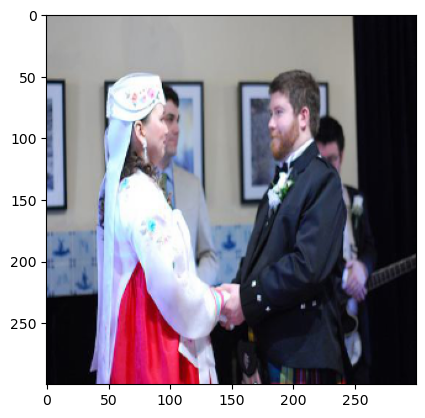

100%|██████████| 15507/15507 [10:50<00:00, 23.82it/s, epoch=15, loss=3.42, lossAvg=2.33]


=> Saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel.pth
=> Done saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel
torch.Size([1, 3, 300, 300])
tensor([ -8.3770,  49.4004,   0.2625,  ...,  -6.4222,  -8.4564, -10.5694],
       device='cuda:0')
tensor([-15.1231, -10.0042,  -5.0873,  ..., -10.5893, -15.3380,  -9.5879],
       device='cuda:0')
tensor([-13.3747,  -7.0685,  -2.8392,  ...,  -7.7263, -13.3664,  -8.9531],
       device='cuda:0')
tensor([-15.0166, -12.2336,  -5.2109,  ..., -10.6532, -15.0223, -10.2216],
       device='cuda:0')
tensor([-18.3136, -17.2108,  -5.7505,  ..., -13.3691, -18.4506, -18.5006],
       device='cuda:0')
tensor([-18.1577, -11.6590,  -4.8401,  ..., -14.8539, -18.1858, -11.0936],
       device='cuda:0')
tensor([-19.8717, -16.7737,  -6.0850,  ..., -16.2054, -20.0073, -14.2200],
       device='cuda:0')
tensor([-16.2908, -14.1409,  -4.9421,  ...,  -9.7884, -16.3330, -10.7221],
       device='cuda:0')
tensor([-19.2128

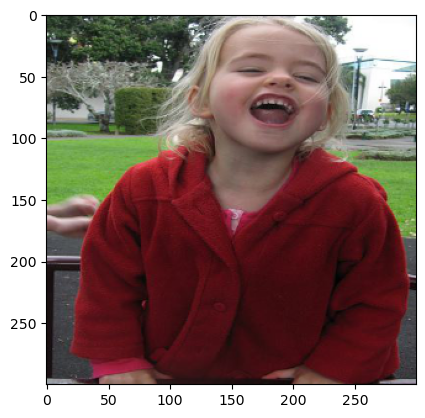

100%|██████████| 15507/15507 [10:42<00:00, 24.15it/s, epoch=16, loss=2.38, lossAvg=2.29]


=> Saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel.pth
=> Done saving checkpoint to ./checkpoints/imageCaptioningEndToEnd/revisitedModel
torch.Size([1, 3, 300, 300])
tensor([-10.0719,  44.7937,   0.9779,  ...,  -4.4318, -10.0409,  -5.1154],
       device='cuda:0')
tensor([-15.6197, -11.2321,  -4.5384,  ..., -14.3496, -15.8186, -10.3447],
       device='cuda:0')
tensor([-14.2119,  -8.1746,  -2.7894,  ..., -12.3251, -14.2336,  -9.0476],
       device='cuda:0')
tensor([-15.1448, -12.8213,  -4.9456,  ..., -14.3632, -15.1611,  -8.6520],
       device='cuda:0')
tensor([-19.3178, -17.6943,  -6.3703,  ..., -19.9143, -19.4462, -19.3088],
       device='cuda:0')
tensor([-18.8891, -11.7590,  -5.8852,  ..., -17.5380, -18.9007, -10.3588],
       device='cuda:0')
tensor([-18.7023, -13.0946,  -6.3157,  ..., -19.2377, -18.7661, -14.4150],
       device='cuda:0')
tensor([-15.3165, -11.3609,  -4.0171,  ..., -13.8456, -15.4119,  -6.1295],
       device='cuda:0')
tensor([-14.1733

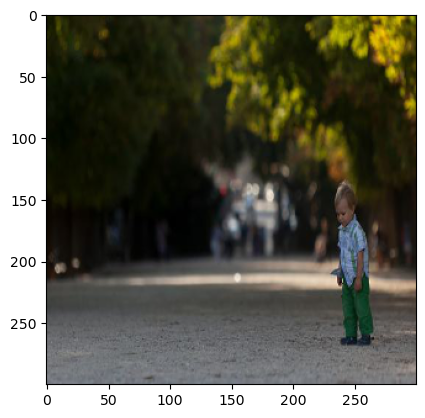

 49%|████▊     | 7533/15507 [05:15<05:33, 23.91it/s, epoch=17, loss=2.83, lossAvg=2.21]


KeyboardInterrupt: 

In [31]:

pathUNetWeights = f"./checkpoints/imageCaptioningEndToEnd/{imageCaptioninglName}"
loadModel = False
saveModel = True
trainModel = True
if loadModel:
  model.loadWeights(pathUNetWeights, optimizer = optimizer,  lr = learningRate)
  model.eval()

  plotAndCaption(model)


if trainModel:
  for epoch in range(numEpoch):

    model.eval()
    #plotAndCaption(model)

    fullImageCaptioning_trainFN(model = model, loader = loader, optimizer = optimizer, criterion = criterion, device = device, epoch = epoch)
    if saveModel:
      model.saveWeights(optimizer, pathUNetWeights, epoch = epoch)


    model.eval()
    plotAndCaption(model)

  """
  Sembra che non riesca ad essere influenzato dalla immagine.
  A questo punto possiamo provare a cambiare il modo di addestramento:
  anzichè fare la prediciton dell'ultimo token, lo facciamo a partire da un elemento a caso
  della caption.

  PRIMA CONTROLLARE CHE COSA VIENE ESATTAMENTE PASSATO COME INPUT NELLA FUNZIONE DI TRAINIG
  """



None


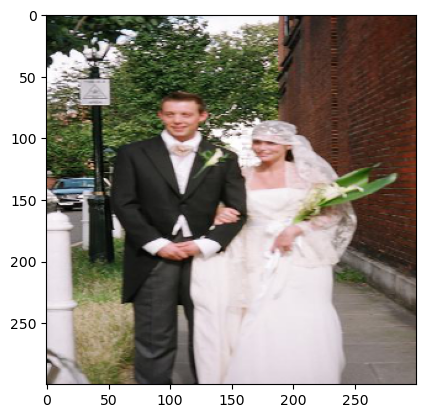

In [ ]:
model.eval()

print(model.captionImage(dataset[45][0].to(device).unsqueeze(0), dataset.vocab))


#plot image

plt.imshow(dataset[45][0].permute(1, 2, 0) * 0.5 + 0.5)
plt.show()


# Image as hidden state
https://www.kaggle.com/code/mdteach/image-captioning-with-attention-pytorch

## Dataset

In [ ]:
import pandas as pd
import os
import spacy        #tokenizer
import torch
from  torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import albumentations as transforms
from albumentations.pytorch import ToTensorV2
import random
import numpy as np

spacyEng = spacy.load("en_core_web_sm")

In [ ]:
class Vocabulary():
    def __init__(self, freqThreshold):
        self.freqThreshold = freqThreshold
        self.intToString = {0: "<PAD>",
                            1: "<SOS>",
                            2: "<EOS>",
                            3: "<UNK>"}
        self.stringToInt = {"<PAD>": 0,
                            "<SOS>": 1,
                            "<EOS>": 2,
                            "<UNK>": 3}
    def __len__(self):
        return len(self.intToString)

    @staticmethod
    def tokenizerEng(text):
        return [tok.text.lower() for tok in spacyEng.tokenizer(text)]


    def buildVocabulary(self, captions):
        frequencies = {}
        index = 4   #we already have used the 0...3 indexed

        for caption in captions:
            for word in self.tokenizerEng(caption):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                if frequencies[word] == self.freqThreshold:
                    self.intToString[index] = word
                    self.stringToInt[word] = index
                    index += 1


    def numericalize(self, caption):
        return [self.stringToInt[word] if word in self.stringToInt
                else self.stringToInt["<UNK>"]
                for word in self.tokenizerEng(caption)]


In [ ]:
class FlickrCaptioning(Dataset):

  def __init__(self, rootDir, captionsPath,
               transform=transforms.Compose([
                        transforms.Resize(height = 300, width = 300),
                        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], max_pixel_value=255),
                        ToTensorV2()
                  ]), targetImageSize = 300,
               freqThreshold = 5, numberOfCaptions = 5):

    if numberOfCaptions > 5:
      print("Max number of captions is 5. Setting 5.")
      numberOfCaptions = 5

    self.rootDir = rootDir
    self.captionsPath = captionsPath
    self.numberOfCaptions = numberOfCaptions

    #read df from pickle

    self.df = pd.read_pickle(captionsPath)  #filename, img_id, caption
    self.transform = transform
    if targetImageSize != 256:
      transform=transforms.Compose([
                        transforms.Resize(height = targetImageSize, width = targetImageSize),
                        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], max_pixel_value=255),
                        ToTensorV2()
                  ])



    self.vocab = Vocabulary(freqThreshold)

    allCaptions = []
    flattenCaption = [] #used for building vocabulary
    for caption in self.df["caption"]:
        allCaptions.append(caption.tolist())
        flattenCaption.extend(caption)


    self.vocab.buildVocabulary(flattenCaption)


  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):

    """
    Returns image and a list of numericalized captions in a list
    (in case there is one caption it will be a list of a single list of numericalized captions)
    """

    imageName = self.df["filename"][index]
    captions = self.df["caption"][index].tolist()

    image = Image.open(os.path.join(self.rootDir, imageName)).convert("RGB")
    #convert to numpy

    image = np.array(image)

    if self.transform is not None:
      image = self.transform(image = image)

      image = image["image"].float()

    numericalizedCaption = []

    
    for caption in captions[:self.numberOfCaptions]:
        tmp = [self.vocab.stringToInt["<SOS>"]]
        tmp.extend(self.vocab.numericalize(caption))
        tmp.append(self.vocab.stringToInt["<EOS>"])
        numericalizedCaption.append(torch.tensor(tmp))
    return image, numericalizedCaption



In [ ]:
class MyCollate:
    def __init__(self, padIDX):
      self.padIDX = padIDX
    def __call__(self, batch):
      imgs = [item[0].unsqueeze(0) for item in batch]
      imgs = torch.cat(imgs, dim=0)

      targets = [random.choice(item[1]) for item in batch]
      targets = pad_sequence(sequences=targets, batch_first=False, padding_value=self.padIDX)

      return imgs, targets

## Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

import numpy as np


In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embedSize, trainCNN = False):
        super(EncoderCNN, self).__init__()
        self.trainCNN = False
        self.embedSize = embedSize

        self.inception = models.inception_v3(pretrained = True, aux_logits = True)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embedSize)
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(0.5)

        for name, param in self.inception.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = self.trainCNN



    def forward(self, images):
        features = self.inception(images)[0]


        x = self.relu(features)
        x = self.dropout(x)

        return x


# Seq2Seq

# Text Generation
## Dataset
import pandas as pd
import os
import spacy        #tokenizer
import torch
from  torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import albumentations as transforms
from albumentations.pytorch import ToTensorV2
import random
import numpy as np

spacyEng = spacy.load("en_core_web_sm")
class Vocabulary():
    def __init__(self, freqThreshold):
        self.freqThreshold = freqThreshold
        self.intToString = {0: "<PAD>",
                            1: "<SOS>",
                            2: "<EOS>",
                            3: "<UNK>"}
        self.stringToInt = {"<PAD>": 0,
                            "<SOS>": 1,
                            "<EOS>": 2,
                            "<UNK>": 3}
    def __len__(self):
        return len(self.intToString)

    @staticmethod
    def tokenizerEng(text):
        return [tok.text.lower() for tok in spacyEng.tokenizer(text)]


    def buildVocabulary(self, captions):
        frequencies = {}
        index = 4   #we already have used the 0...3 indexed

        for caption in captions:
            for word in self.tokenizerEng(caption):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                if frequencies[word] == self.freqThreshold:
                    self.intToString[index] = word
                    self.stringToInt[word] = index
                    index += 1


    def numericalize(self, caption):
        return [self.stringToInt[word] if word in self.stringToInt
                else self.stringToInt["<UNK>"]
                for word in self.tokenizerEng(caption)]
class FlickrCaptions(Dataset):

  def __init__(self, captionsPath,
               freqThreshold = 5,
               numberOfCaptions = 5):

    if numberOfCaptions > 5:
      print("Max number of captions is 5. Setting 5.")
      numberOfCaptions = 5

    self.captionsPath = captionsPath

    #read df from pickle

    self.df = pd.read_pickle(captionsPath)  #filename, img_id, caption




    self.vocab = Vocabulary(freqThreshold)

    allCaptions = []
    flattenCaption = [] #used for building vocabulary
    for caption in self.df["caption"]:
        allCaptions.append(caption.tolist())
        flattenCaption.extend(caption)


    self.vocab.buildVocabulary(flattenCaption)


  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):

    """
    Returns image and a list of numericalized captions in a list
    (in case there is one caption it will be a list of a single list of numericalized captions)
    """


    captions = self.df["caption"][index].tolist()



    numericalizedCaptions = []

    for caption in captions:
        tmp = [self.vocab.stringToInt["<SOS>"]]
        tmp.extend(self.vocab.numericalize(caption))
        tmp.append(self.vocab.stringToInt["<EOS>"])
        numericalizedCaptions.append(torch.tensor(tmp))
    return numericalizedCaptions


class MyCollate:
    def __init__(self, padIDX):
      self.padIDX = padIDX
    def __call__(self, batch):

      targets = [random.choice(item) for item in batch]
      targets = pad_sequence(sequences=targets, batch_first=False, padding_value=self.padIDX)

      return targets
dataset = FlickrCaptions(captionsPath = "./train/captions/captions.pkl")
loader = DataLoader(dataset = dataset, batch_size = 2, shuffle = True, collate_fn = MyCollate(padIDX = dataset.vocab.stringToInt["<PAD>"]), pin_memory=True)
for x in loader:
  print(x)
  break
## The model
#The image will be passed as the hidden state of the LSTM.
class LSTMnoImages(nn.Module):
  def __init__(self, embedSize, hiddenSize, vocabSize, numLayers):
    super(LSTMnoImages, self).__init__()

    self.embed = nn.Embedding(vocabSize, embedSize)
    self.lstm = nn.LSTM(embedSize, hiddenSize, numLayers)
    self.linear = nn.Linear(hiddenSize, vocabSize)
    self.dropout = nn.Dropout(0.5)

  def forward(self, features, captions, captionLenghts = 50):
    embeddings = self.dropout(self.embed(captions))

    #the features have to be passed as the hidden state to the lstm
    if features is not None:
      hidden = features
    else:
      #give an initial hidden state
      hidden = (torch.zeros(1, captions.shape[1], self.lstm.hidden_size),
                torch.zeros(1, captions.shape[1], self.lstm.hidden_size))
      print(f"Hidden size before: {hidden[0].shape}")

    output, hidden = self.lstm(embeddings, hidden)
    output = self.linear(output)
    return output






LSTMModel = LSTMnoImages(embedSize = 256, hiddenSize = 256, vocabSize = len(dataset.vocab), numLayers = 1)
LSTMModel_before = LSTMnoImages(embedSize = 256, hiddenSize = 256, vocabSize = len(dataset.vocab), numLayers = 1)
for x in loader:
  output = LSTMModel(None, x)
  print(output.shape)
  print(output)
  break